# Ⅰ. 트랜스포머 내부 모듈
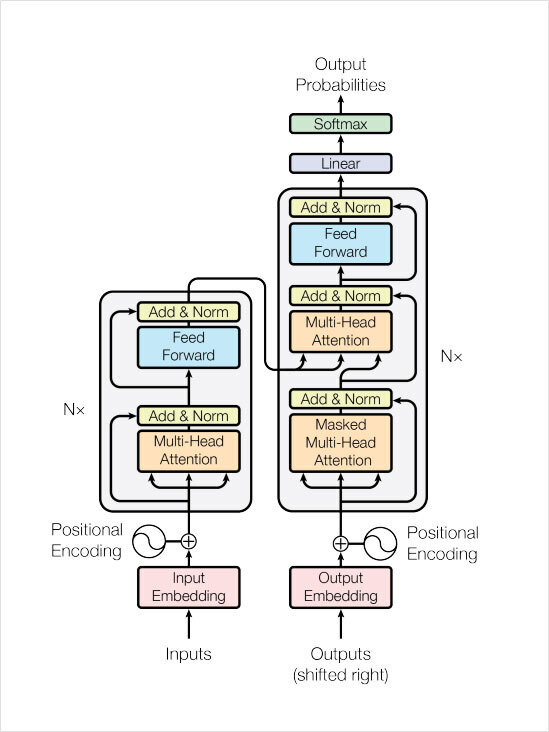

# 1. Positional Encoding
## (1) Sequence를 대체한 Positional Encoding

## (2) Positional Encoding 방법과 한계
1) 각 단어에 0~1 사이의 값을 더한다. 0을 첫 번째 단어로, 1을 마지막 단어로 한다.  
-> 문장의 길이에 따라 더해지는 값이 가변적이다. 따라서 단어 간의 거리(Delta)가 일정하지 않다.  
2) 각 단어에 선형적으로 증가하는 정수를 더한다.  
-> 단어 간의 거리(Delta)가 일정해지는 것은 좋지만 범위가 무제한이기 때문에 값이 매우 커질 수 있고 모델이 일반화하기 어려워진다.  

## (3) 만족조건
1) 각 Time-step마다 고유의 Encoding 값을 출력해야 한다.  
2) 서로 다른 Time-step이라도 같은 거리라면 차이가 일정해야 한다.  
3) 순서를 나타내는 값이 특정 범위 내에서 일반화가 가능해야 한다.  
4) 같은 위치라면 언제든 같은 값을 출력해야 한다.  
  => 만족조건 충족하는 수식 : sinusoid()함수

# 2. Multi-Head Attention
## (1) Scaled Dot-Product Attention

### 1) 전통적 어텐션
- 어텐선 : 디코더의 포지션 i에서 바라본 인코더의 context vector ci 를 해석하기 위해, 인코더의 각 포지션 j에 부여한 가중치
    => 이 가중치는 디코더의 state si 와 인코더의 state hj 사이의 유사도를 통해 계산됨

### 2) Dot-Product Attention
- 전통적 어텐션과 원리는 동일
- 디코더의 state를 Q(query)라고 부르고, 인코더의 state를 K(key)라고 추상화함.
- Q와 K의 유사도를 dot product로 계산한 후 소프트맥스 함수에 적용
   => 하나의 Query와 모든 Key들 사이의 연관성(유사도)을 계산한 후 그 값을 확률값으로 만든다.
        (이는 Query가 어떤 Key와 높은 확률로 연관이 있는지 계산함)
- 계산된 가중치와 V의 곱이 어텐션의 최종값이 됨
- Scale 과정(1/sqrt(d))
   => Embedding 차원 수가 깊어지면 깊어질수록 Dot-Product의 값은 커지게 되어 Softmax를 거치고 나면 미분값이 작아지는 현상이 나타난다. 이를 대비한 스케일 조정 작업이 필요함.

## (2) Causality Masking
- 자기 회귀(autoregressive) : 자기 자신을 입력으로 하여 자기 자신을 예측
- 트랜스포머 : 병렬처리, 시퀀서 성격 상실 
- 인과관계 마스킹은 자기 회귀적 특성 살리기 위해, 인위적으로 연속성을 학습하게 함.
- 인과 관계 마스크는 대각항을 포함하지 않는 삼각 행렬의 모양새
  => \<start> 토큰을 활용해 마스크가 대각항을 포함하지 않는 형태
-  마스킹은 마스킹 할 영역을 -∞로 채우고 그 외 영역을 0으로 채운 배열을 Dot-Product된 값에 더해주는 방식
  => 후에 진행될 Softmax는 큰 값에 높은 확률을 할당하는 함수이므로 -∞로 가득 찬 마스킹 영역에는 무조건 0의 확률을 할당하게 됨

## (3) Multi-Head Attention
- Embedding된 10개 단어의 문장이 [10, 512]의 형태를 가진다면, Multi-Head Attention은 이를 [10, 8, 64]로 분할하여 연산합니다. 각 64차원의 Embedding을 독립적으로 Attention한 후, 이를 이어붙여 다시금 [10, 512]의 형태로 되돌리며 연산은 끝이 납니다
- Embedding들끼리 유사한 특성을 가지도록 하기 위해 앞단에 Linear 레이어를 추가
  => Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할
- 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장을 위해
   => 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거침.

# 3. Position-wise Feed-Forward Networks
-  예를 들면 10단어로 이루어진 Attention된 문장 [10, 512]를 [10, 2048] 공간으로 매핑, 활성함수를 적용한 후 다시 [10, 512] 공간으로 되돌리는 것   
- Position-wise라는 수식어가 붙은 이유는 FFN 연산이 개별 단어(Position)마다 적용되기 때문이다. seperatly and identically    
- 트랜스포머는 여러 개의 인코더와 디코더를 쌓아 완성되지만, 각 레이어의 Position-wise Feed-Forward Network는 서로 다른 파라미터를 사용한다.

# Ⅱ. 모듈 구현/조립 및 학습

# 1. 모둘 구현
- 최초의 텍스트 입력 데이터는 [ batch_size x length ] 의 형태   
    => 번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태    
- 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복    
    => 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지를 눈여겨봅시다.   

### [텐서의 shape 변화 과정]
1. 입력 데이터 → [ batch_size x length ]   
2. Source & Target Embedding → [ batch_size x length x d_emb ]   
3. Positional Encoding 2번의 결과에 더해지므로 shape 변화는 없음   
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재   
   1) Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]   
   2) Masking for Masked Attention   
   3) Scaled Dot Product Attention   
   4) Combine Heads →[ batch_size x length x d_emb ]   
5. Residual Connection   
6. Layer Normalization   
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]   
8. Output Linear Layer → [ batch_size x length x vocab_size ]   

## (1) Positional Encoding

## (2) Multi-Head Attention
- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됨  
① split_heads() : Embedding된 입력을 Head 수로 분할  
② scaled_dot_product_attention() : 분할된 입력으로부터 Attention 값을 구함   
③ combine_heads() : 연산이 종료되고 분할된 Head를 다시 하나로 결합   

- Masking 부분  
  => 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의됨  
  => 마스크를 생성하는 함수는 모델을 완성한 후에 구현. 

## (3) Position-wise Feed-Forward Network
-  [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후,  다시 w_2 를 통해 512차원으로 되돌리는 과정

# 2. 모둘 조립
- 레이어 수를 원하는 만큼 쌓아 모델을 완성    
  => 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의       
  => Layer 클래스를 정의 방법 숙지

## (1) Encoder Layer 구현하기
- Transformer의 구현, Normalization Layer의 위치에 대한 논의   
  => 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현   
  => 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용  
        ※ 후자 추천(경험 : 다층구조일수록 더 좋은 성능)
        ※ 관련 논문 : On Layer Normalization in the Transformer Architecture
                      (모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명)

## (2) Decoder Layer 구현하기
- EncoderLayer 클래스를 참고하여 DecoderLayer 클래스를 완성
- EncodeLayer 와 DecoderLayer 를 모두 정의했으니 이를 조립하여 Encoder와 Decoder 클래스를 정의

## (3) Transformer 완성하기
### [주요 조건]
- shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는 것, 잊지 않으셨죠?   
    ※ (참고: tf.keras.layers.Layer.set_weights())
- 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요!   
    ※ (참고: tf.expand_dims(), np.newaxis)

# 3. 조력자들

## (1) Masking
- generate_padding_mask()
- generate_causality_mask()
- generate_masks()
   => Attention을 할 때에 \<PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할
- Encoder Mask : 각 배치 별로 데이터의 꼬리 부분을 마스킹하는 형태
- Encoder-decoder Mask : Causality Mask와 Padding Mask 결합한 형태
- Decoder Mask : Causality Mask와 Padding Mask 결합한 형태
  => 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹
  => 인과관계 가리는 것과 디코더 역시 \<PAD>토큰을 피해가야 함

## (2) Learning Rate
- 최적화 함수 : Adam   
- Learning Rate :초기에는 선형으로 증가하고, 일정시점 이후에는 단계에 따라 점차 감소하는 형태로 적용

## (3) Layer Normalization
- Layer Normalization :  데이터를 Feature 차원에서 정규화를 하는 방법임   
  => 10단어의 Embedding된 문장을 예로 들면 [10, 512]에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰주는 것이다.   
- 정규화 : 데이터 특성(feature)의 척도를 직접 조정하는 방법   
- 배치 정규화와 층 정규화의 차이   
  =>Batch Normalization은 정규화를 Batch 차원에서 진행하는 것이고 Layer Normalization은 정규화를 Feature 차원에서 진행하는 것이다.

## (4) Residual Connection
- 2015년 ResNet 모델을 소개하면서 제안된 개념    
- 상식적으로 56개의 레이어를 갖는 네트워크는 20개의 레이어를 갖는 네트워크보다 성능이 좋아야 합니다. 하지만 그렇지 않은 이유는 네트워크가 깊어질 수록 Optimize(Train)하는 것이 어렵기 때문이다.

## (5) Weight Sharing
- 모델의 일부 레이어가 동일한 사이즈의 가중치를 가질 때 사용하는 기법  
  => 하나의 가중치를 두 개 이상의 레이어가 동시에 사용  
  => 언어모델, Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 가중치 가짐.  
- 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 유리하고 자체적으로 Regularization효과 지님  
- 트랜스포머, 디코더의 Embedding 레이어와 출력층 Linear 레이어의 가중치를 공유함.  
   => 경우에 따라서는 소스와 타겟 Embedding 레이어까지 공유할 수도 있다.(언어의 유사성)  
- 출력층 Linear 레이어와 Embedding 레이어의 Feature분포가 다름  
  => Embedding 값에 d_model의 제곱근값을 곱해줌  
  => 이는 분포를 맞춰줌과 동시에 Positional Embedding이 Embedding값에 큰 영향을 미치는 것을 방지  

# Ⅲ. 프로젝트 : 더 나은 번역기

# Step 1. 데이터 다운로드 (클라우드 유저용)

In [ ]:
$ ln -s ~/data ~/aiffel/NLP/10_transformer/data

In [1]:
import numpy as np
import tensorflow as tf

import re
import os
import io
import time
import random

import sentencepiece as spm
from tqdm import tqdm_notebook

print(tf.__version__)

2.4.1


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn # Attention 시각화를 위해 필요!

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


# Step 2. 데이터 정제 및 토큰화

## (1) 데이터 정제
set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/NLP/10_transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
        
    print("Data Size:", len(kor))
    print("Example:")
    for sen in kor[0:100][::20]: print(">>", sen)
    
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    
    print("\nData Size:", len(eng))
    print("Example:")
    for sen in eng[0:100][::20]: print(">>", sen)
    
    assert len(kor) == len(eng)
        
    return kor, eng

kor_data,eng_data = clean_corpus(kor_path, eng_path)

cleaned_corpus = set(zip(kor_data,eng_data))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give t

정제 함수를 아래 조건을 만족하게 정의하세요.

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [4]:
def preprocess_sentence_ko(sentence):
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence


def preprocess_sentence_en(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [7]:
kor_corpus = []
eng_corpus = []

for i in cleaned_corpus:
    
    temp_kor = preprocess_sentence_ko(i[0])
    temp_eng  = preprocess_sentence_en(i[1])
    kor_corpus.append(temp_kor)
    eng_corpus.append(temp_eng)

In [5]:
# kor_corpus = []
# eng_corpus = []

# for pair in cleaned_corpus:
#     k, e = pair.split("\t")

#     kor_corpus.append(preprocess_sentence(k))
#     eng_corpus.append(preprocess_sentence(e))

AttributeError: 'tuple' object has no attribute 'split'

In [8]:
print(f'한글 문장 : {len(kor_corpus)}')
print(f'영어 문장 : {len(eng_corpus)}\n')

print(f'[ 한글 문장 예시 ]\n {kor_corpus[100]}\n')
print(f'[ 영어 문장 예시 ]\n {eng_corpus[100]}\n')

한글 문장 : 78968
영어 문장 : 78968

[ 한글 문장 예시 ]
 서울에 있는 러시아 대사관의 일부 관리들은 러시아가 강국 중 마지막 에 위치한 이 대통령의 해외 방문 일정에 대해 불만스러운 것으로 알려졌다 .

[ 영어 문장 예시 ]
 some officials at the russian embassy in seoul were reportedly discontented with lee s overseas visit schedule in which russia is placed last of the four powers .



한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다. 
토큰화에는 Sentencepiece를 활용하세요. 
첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 
최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. 
en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 
타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
  \<PAD> : 0 \/ \<BOS> : 1 \/ \<EOS> : 2 \/ \<UNK> : 3

In [9]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang,
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    file = f'./{lang}_corpus.txt'
    model = f'{lang}_spm'
    
    with open(file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
            
    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        f'--input=./{file} --model_prefix={model} --vocab_size={vocab_size}' + \
        f'--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{model}.model')

    return tokenizer

In [10]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [11]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for i in tqdm_notebook(range(len(kor_corpus))):

    src_tokens = ko_tokenizer.encode_as_ids(kor_corpus[i])
    tgt_tokens = en_tokenizer.encode_as_ids(eng_corpus[i])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)

len(src_corpus)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/78968 [00:00<?, ?it/s]

68324

In [12]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')


# Step 3. 모델 설계

## Positional Encoding

In [13]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

## Generate Padding Mask

In [14]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Multi Head Attention

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

## Position-wise Feed Forward Network

In [16]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

## EncoderLayer

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

## Decoder Layer

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## Encoder

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

## Decoder

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer(Full Model)

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [22]:
VOCAB_SIZE = 20000   ### 다시확인
N_LAYERS= 2
D_MODEL = 512
N_HEADS = 8
D_FF    = 2048
DROPOUT = 0.3


transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=DROPOUT,
    shared_fc=True,
    shared_emb=True)

d_model = 512

# Step 4. 훈련하기

## Learning Rate Scheduler

In [23]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## Learning Rate & Optimizer

In [24]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

## Loss Function

In [25]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Train Step

In [26]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## Attention 시각화 함수

In [27]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

## 번역 생성 함수

In [28]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence_ko(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

## 번역 생성 및 Attention 시각화 결합

In [29]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [30]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

## Train

In [31]:
import warnings

warnings.filterwarnings(action='ignore') 



In [ ]:
import random
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15



for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    print('Translations')
    for i in sentences:
        translate(i, transformer, ko_tokenizer, en_tokenizer, plot_attention=False)
    print('\n','Hyperparameters')
    print('> n_layers:', N_LAYERS)
    print('> d_model:', D_MODEL)
    print('> n_heads:', N_HEADS)
    print('> d_ff:', D_FF)
    print('> dropout:', DROPOUT)
    print('\n','Training Parameters')
    print('> Warmup Steps: 4000')
    print('> Batch Size: 64')
    print('> Epoch At', epoch+1)

  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president elect barack obama s president elect is a president of the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were in the u . s . s .
Input: 커피는 필요 없다.
Predicted translation: they of the associated press .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the days were killed in the dead .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 1


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama is a obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee coffees are coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 2


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is ahead of obama s victory .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s office is a nice neighborhood .
Input: 커피는 필요 없다.
Predicted translation: it s not just likely to be a full time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two deaths were killed .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 3


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a president of president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of maryland is a new river in new mexico city .
Input: 커피는 필요 없다.
Predicted translation: coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventeen were among the dead .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 4


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is a president of president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of the city of new york .
Input: 커피는 필요 없다.
Predicted translation: no matters of coffee is no needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 5


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president is the president of the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of new cities .
Input: 커피는 필요 없다.
Predicted translation: it needs to keep coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died saturday .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 6


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama is live .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is increasing the city s god .
Input: 커피는 필요 없다.
Predicted translation: no coffee is no rar . no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died saturday .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 7


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the increasingly highest cities in the city .
Input: 커피는 필요 없다.
Predicted translation: it needs coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were seven saturday .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 8


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president gave his support mr .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the citing city of ve offering new cities cities in the city .
Input: 커피는 필요 없다.
Predicted translation: it s no peru of coffee in the caffeine of coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were seven saturday .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 9


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president barack obama has faced his question of his president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the citizens in the city .
Input: 커피는 필요 없다.
Predicted translation: it s good with coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 10


  0%|          | 0/1068 [00:00<?, ?it/s]

Translations
Input: 오바마는 대통령이다.
Predicted translation: the president is live .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the cities of the cities of the citizens .
Input: 커피는 필요 없다.
Predicted translation: it needs coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were dead .

 Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

 Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At 11


  0%|          | 0/1068 [00:00<?, ?it/s]

# Ⅳ. 결론

## 1. 결과 분석
- 훈련과정 : 각 에폭마다 7분 초반대 소요, loss는 5.7313에서 차츰 감소하여 10에포에서는 0.8564
- seq2seq보다 문장이 만들어질려는 듯 했으나 여전히 제대로 된 문장이 만들어지지 않았다.
  많은 훈련을 한다면 가능하리라 본다.

## 2. 후기 및 차후 과제
- 토큰 길이 설정을 50이하로 국문/영문을 동일하게 적용하였는데, 문장들의 길이를 분석하여 차등할 필요가 있다.
- 모듈마다의 대략적인 개념은 알겠는데 실제 구현으로 들어가면 또 새롭다.(나이들어 그런가보다 T.T)
- 텐서의 변화에 대해 막연하게 꼬이고 정리되지않아 힘들어었는데 이번에는 구현단계에서 정리해주니 도움이 되었다.(물론 완전히 이해되지 않지만, 이렇게 접근하는게 맞구나하는 느낌이 들었다.)
- 눈으로 코딩을 익히는 것으로는 한계가 있다는 것을 느꼈다. 점점 더 난이도가 높은 코딩을 원한다.(학습도중 코딩을 하라는 과제) 방학을 지내면서 느낀점으로 남은 기간동안에는 코딩을 베끼는 쪽으로 학습방법을 바꾸기로 하였다.
- 어텐션이 여기저기 많이 사용되는데 핵심적인 개념이 무엇인지 아직 잘 모르겠다. 코딩에서 구현되는 부분도 아직 뚜렷하게 구분하지 못하고 있다. 
- 학습내용중에 갑자기 BLEU라는 단위가 나와 구글링해서 대략적인 개념은 이해하고 따로 학습해야 하는줄 알고 나름 코드도 보고 했는데 다음 단계에서 심층적으로 들어갔다. 역시 씨줄날줄로 연결되어 있으니 조급해하지말고 단계단계 따라가자.....